In [1]:
import numpy as np
import pandas as pd
import FinanceDataReader as fdr
        
import matplotlib as mpl
%matplotlib inline
mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import Image as Img

import glob
import argparse
import os

import shutil
import psutil
from pathlib import Path
from mpl_finance import candlestick2_ochl, volume_overlay

C:\Users\SeungHyuck\anaconda3\lib\site-packages\mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
# 파일 위치 = filedir\\
# 파일 이름 = filename
# 파일 경로 = filepath = filedir\\filename

def removeOutput(filepath):
    if(Path(filepath)).is_file():
        os.remove(filepath)
    
def csv_initiator(market, ticker, head_date, tail_date):
    df = fdr.DataReader(ticker, head_date, tail_date, exchange=market)
    
    filedir = os.getcwd() + '\\dataset\\raw_data\\'
    filename = "{}_{}.csv".format(market, ticker)    
    filepath = filedir + filename
    
    if not os.path.exists(filedir):
        os.makedirs(filedir)    
    removeOutput(filepath)
    df.to_csv(filepath)
    
    print("csv file saved as : {}".format(filepath))
    
    return filepath

In [3]:
def seqEnd_trend(csv_path, seq_len):
    print("Creating label . . .")
    print("type : sequence_end")
    
    # 데이터프레임으로 일일주가데이터 불러오기, 결측치 제거
    df = pd.read_csv(csv_path, parse_dates=True, index_col=0)
    df.fillna(0)
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num) # Y-M-D 포멧에서 num 포멧으로 변경
        
    # 파일을 저장할 디렉토리 명과 파일이름 지정
    filedir = os.getcwd() + '\\dataset\\labeled_data\\'
    filename = "{}_label_seq{}.txt".format(csv_path.split('\\')[-1][0:-4], seq_len) # ex) KRX_005930_label_seq30 
    filepath = filedir + filename
        
    # 디렉토리가 없을시 생성, 같은이름의 파일 제거
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    removeOutput(filepath)

    # 레이블링
    for i in range(0, len(df)-int(seq_len)-1):
        tmp_df = df.iloc[i:i + int(seq_len)+1]  # seq_len+1 만큼 데이터프레임 슬라이싱
        starting = int(tmp_df["Close"].iloc[-2]) # seq 마지막날 종가
        endvalue = int(tmp_df["Close"].iloc[-1]) # seq 다음날 종가
        tmp_rtn = endvalue / starting - 1 
        
        if tmp_rtn > 0:
            label = 1
        else:
            label = 0
        # 레이블링한 sequence를 한 라인으로 파일에 입력        
        with open(filepath, 'a') as the_file:
            the_file.write("{}--{},{}".format(filename[0:-4], i, label))
            the_file.write("\n")

    print("Create label finished.")
    print("labeld file saved as : ", filepath)
    return filepath

In [4]:
def ohlc2cs(csv_path, seq_len, dimension, use_volume):
    print("Converting ohlc to candlestick")

    # 데이터프레임으로 일일주가데이터 불러오기, 결측치 제거
    df = pd.read_csv(csv_path, parse_dates=True, index_col=0)
    df.fillna(0)
    df.reset_index(inplace=True)
    df['Date'] = df['Date'].map(mdates.date2num) # Y-M-D 포멧에서 num 포멧으로 변경
    
    # 파일을 저장할 디렉토리 명과 파일이름 지정
    symbol = csv_path.split('\\')[-1][0:-4]
    filedir = os.getcwd() + '\\dataset\\candle_chart\\{}\\seq{}_dim{}_vol{}\\'.format(
                                symbol, seq_len, dimension, use_volume) # ex) seq30_dim536_volFalse
    
    # 디렉토리가 없을시 생성, 이미 디렉토리가 있다면 내용물 삭제하고 다시 생성
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    else:
        shutil.rmtree(filedir)
        os.makedirs(filedir)
    
    plt.style.use('dark_background') # 배경을 검은색으로
    
    for i in range(0, len(df)-int(seq_len)-1):
        tmp_df = df.iloc[i:i + int(seq_len)]
        if len(tmp_df) == int(seq_len):
            my_dpi = 109 # 자신의 모니터에 맞는 dpi 설정 27inch qhd -> 109
            fig = plt.figure(figsize=(dimension / my_dpi, dimension / my_dpi), dpi=my_dpi) # figure size 설정
            ax1 = fig.add_subplot(1, 1, 1)
            
            # Open, Close, High, Low column을 arguments로 넘겨준다.
            candlestick2_ochl(ax1, tmp_df['Open'], tmp_df['Close'], tmp_df['High'], tmp_df['Low'],
                                width=1, colorup='#ed3738', colordown='#0a7df3')
            
            # 학습에 필요한 부분만 남도록 정리
            ax1.grid(False)
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            ax1.xaxis.set_visible(False)
            ax1.yaxis.set_visible(False)
            ax1.axis('off')
                        
            if use_volume: # volume 정보를 사용할 경우에
                ax2 = ax1.twinx()
                bc = volume_overlay(ax2, tmp_df['Open'], tmp_df['Close'], tmp_df['Volume'],
                                        colorup='#ed3738', colordown='#0A7df3',
                                        alpha=0.5,  width=1)
                ax2.add_collection(bc)
                
                # 학습에 필요한 부분만 남도록 정리
                ax2.grid(False)
                ax2.set_xticklabels([])
                ax2.set_yticklabels([])
                ax2.xaxis.set_visible(False)
                ax2.yaxis.set_visible(False)
                ax2.axis('off')
            
            filename = '{}-{}'.format(symbol, i)
            filepath = filedir + filename
            fig.savefig(filepath, pad_inches=0, transparent=False)
            plt.close(fig)
            
    print("Converting ohlc to candlestick finished")
    return filedir

In [5]:
# main
market = 'KRX'
ticker = '005930'
seq_len = '20'
head_date = '2021-01-01'
tail_date = '2022-01-01'
dimension = 327
use_volume = False

data_csv_path = csv_initiator(market, ticker, head_date, tail_date)
label_set_path = seqEnd_trend(data_csv_path, seq_len)
candlechart_dir = ohlc2cs(data_csv_path, seq_len, dimension, use_volume)

csv file saved as : C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\ML Quant Strategy\CandleChart_Binary_Classifier\dataset\raw_data\KRX_005930.csv
Creating label . . .
type : sequence_end
Create label finished.
labeld file saved as :  C:\Users\SeungHyuck\Documents\github_remote\AI-Trade\ML Quant Strategy\CandleChart_Binary_Classifier\dataset\labeled_data\KRX_005930_label_seq20.txt
Converting ohlc to candlestick
Converting ohlc to candlestick finished


In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [7]:
# 캔들차트이미지를 데이터 셋으로
# 한 픽셀의 RGB 값, 한 변의 픽셀 수는 dimension
# im.save('my_img.jpg')    # 이미지 저장
# im.crop((10, 20, 30, 40))    # 이미지 잘라내기 (좌, 상, 우, 하 순서)
# im.resize((512, 512))    # 이미지 크기 변경하기
# im.rotate(25)    # 이미지 25도 회전하기 (60분법 사용)

from PIL import Image
def image2dataarray(candlechart_dir):
    symbol = candlechart_dir.split('\\')[-3]
    imgs = list([])
    for i in range(len(os.listdir(candlechart_dir))):
        imgname = '{}-{}.png'.format(symbol, i)
        im = Image.open(candlechart_dir+imgname)
        pixels = list(im.getdata())
        img = list([])
        for pixel in pixels:
            for j in range(3): # Excepting alpha value
                img.append(pixel[j])
        imgs.append(img)
        # print(imgs)
    return np.array(imgs)

def label2dataarray(label_set_path):
    label_array = list([])
    with open(label_set_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            label = int(line.split(',')[-1])
            label_array.append(label)
        return np.array(label_array)

In [16]:
candle_array = image2dataarray(candlechart_dir)
label_array = label2dataarray(label_set_path)
print(len(candle_array), len(label_array))

2941 2941


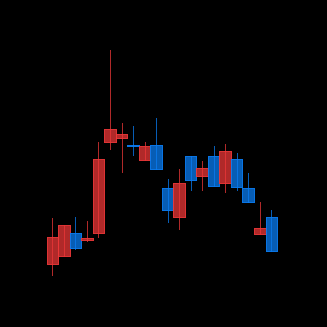

In [24]:
Img(filename=candlechart_dir+'KRX_005930-0.png', height=327, width=327)

In [98]:
X_all = candle_array
y_all = label_array
slicer = 2600
X_train = X_all[:slicer]
y_train = y_all[:slicer]
X_test = X_all[slicer:]
y_test = y_all[slicer:]

In [99]:
sgd_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("sgc", SGDClassifier(loss='hinge', penalty='l2',epsilon=0.1, alpha=0.0001, n_jobs=-1,
                                         random_state=42))
])
sgd_cla.fit(X_train, y_train)
print("train_set score: ", sgd_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", sgd_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  0.7492307692307693
test_set score :  0.5356125356125356


In [93]:
unique, counts = np.unique(sgd_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[172 181]


In [84]:
svm_cla = Pipeline([
                    ("scaler", StandardScaler()),
                    ("svc", SVC()),
            ])
svm_cla.fit(X_train, y_train)
print("train_set score: ", svm_cla.score(X_train, y_train)) # 훈련세트 점수
print("test_set score : ", svm_cla.score(X_test, y_test)) # 검증세트 점수

train_set score:  0.9173076923076923
test_set score :  0.4757834757834758


In [85]:
unique, counts = np.unique(svm_cla.predict(X_test), return_counts=True)
print(unique)
print(counts)

[0 1]
[179 172]
